[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1G9kuChta83-Yg5AWjduErTMfVdmn-Rqj?usp=sharing)

In [ ]:
#@title Import and Setup Onshape Client

!pip install onshape-client
from onshape_client.client import Client
from onshape_client.onshape_url import OnshapeElement
import json

#@markdown Chage the base if using an enterprise (i.e. "https://ptc.onshape.com")
base = 'https://cad.onshape.com' #@param {type:"string"}

#@markdown Would you like to import your API keys from a file, or copy and paste them directly?
keyImportOption = "Upload Keys from File" #@param ["Upload Keys from File", "Copy/Paste Keys"]

from IPython.display import clear_output 
clear_output()
print("Onshape Client successfully imported!")

if keyImportOption == "Upload Keys from File":
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    execfile(fn)

  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')
else:
  access = input("Paste your Onshape Access Key: ")
  secret = input("Paste your Onshape Secret Key: ")
  client = Client(configuration={"base_url": base,
                                "access_key": access,
                                "secret_key": secret})
  clear_output()
  print('Onshape client configured - ready to go!')


Onshape client configured - ready to go!


# Testing Out the Components

In [ ]:
#@title 1. Get Assembly Definition
#@markdown Function `getAssemblyDefinition(url: str)` returns JSON of all parts in a document. The URL can be any element from the document.
url = 'https://cad.onshape.com/documents/9956cf02c4db09c32d653307/w/a08b90943f6b539764b5c942/e/a3566547896a300e872e6e80' #@param {type:"string"}
showResponse = False#@param {type:"boolean"}
listParts = True#@param {type:"boolean"}
def getAssemblyDefinition(url: str):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid'

  element = OnshapeElement(url)
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  method = 'GET'

  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)

  parsed = json.loads(response.data)
  return parsed

assemblyDefinitionResponse = getAssemblyDefinition(url)

if showResponse:
  print(json.dumps(assemblyDefinitionResponse, indent=4, sort_keys=True))
if listParts:
  for instance in assemblyDefinitionResponse['rootAssembly']['instances']:
    name = instance['name']
    id = instance['id']
    print(f'Part named {name} has id {id}')
else:
  pass

Part named Floating <1> has id MNWQfqrVC05WHKYbh
Part named Ground <1> has id MH0M+UNhQOh7RSwCy
Part named Input <1> has id MDvG2pH15Y8xzO/7p
Part named Output <1> has id Muc4HLuNq7SMwWeP9
Part named Pin <1> has id MyLbevSULLFTNlF1t
Part named Pin <2> has id MoU7QyyqWRpFwKGr/
Part named Pin <3> has id MoH8UrjsRsuPW0Yrs
Part named Pin <4> has id MfKnKOz47lU6KDvP2
Part named Position Tracker <1> has id MrKVHwm/CqMOEFTa7
Part named Position Tracker <2> has id M7jknQrPGALQtDQ4j


## 2. Turn the input of the four-bar mechanism

In [ ]:
#@title Run this cell to load matrix helper functions

import math
import numpy

def IdentitySixteen():
  m = [
      1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1
      ]
  return m

def DiceTransform(value):
    switcher = {
        0: [
            0, 0, 1, 0,
            0, 1, 0, 0,
            -1, 0, 0, 0,
            0, 0, 0, 1
           ],
        1: [
            0, 0, 1, 0,
            0, 1, 0, 0,
            -1, 0, 0, 0,
            0, 0, 0, 1
           ],
        2: [
            1, 0, 0, 0,
            0, 0, 1, 0,
            0, -1, 0, 0,
            0, 0, 0, 1
           ],
        3: [
            1, 0, 0, 0,
            0, -1, 0, 0,
            0, 0, -1, 0,
            0, 0, 0, 1
           ],
        4: [
            1, 0, 0, 0,
            0, 1, 0, 0,
            0, 0, 1, 0,
            0, 0, 0, 1
           ],
        5: [
            1, 0, 0, 0,
            0, 0, -1, 0,
            0, 1, 0, 0,
            0, 0, 0, 1
           ],
        6: [
            0, 0, -1, 0,
            0, 1, 0, 0,
            1, 0, 0, 0,
            0, 0, 0, 1
           ] 
    }
  
    # get() method of dictionary data type returns 
    # value of passed argument if it is present 
    # in dictionary otherwise second argument will
    # be assigned as default value of passed argument
    return switcher.get(value, "nothing")

def DiceMove(value,x1,y1):
  matrix = DiceTransform(value)
  matrix[3] = x1
  matrix[7] = y1
  return matrix

def DiceFollow(diceMatrix,tcpMatrix):
  diceMatrix[3] = tcpMatrix[3]
  diceMatrix[7] = tcpMatrix[7]
  diceMatrix[11] = tcpMatrix[11]
  return diceMatrix
  
def sixteenToFourByFour(matrix):
  fourbyfour = [[matrix[0],matrix[1],matrix[2],matrix[3]],
                [matrix[4],matrix[5],matrix[6],matrix[7]],
                [matrix[8],matrix[9],matrix[10],matrix[11]],
                [matrix[12],matrix[13],matrix[14],matrix[15]]]
  return fourbyfour

def fourByFourToSixteen(matrix):
  sixteen = [matrix[0][0],matrix[0][1],matrix[0][2],matrix[0][3],
             matrix[1][0],matrix[1][1],matrix[1][2],matrix[1][3],
             matrix[2][0],matrix[2][1],matrix[2][2],matrix[2][3],
             matrix[3][0],matrix[3][1],matrix[3][2],matrix[3][3]]
  return sixteen

def clockwiseSpinX(theta):
  m = [[1, 0, 0, 0],
       [0, math.cos(theta), math.sin(theta), 0],
       [0, -math.sin(theta), math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinY(theta):
  m = [[math.cos(theta), 0, math.sin(theta), 0],
       [0, 1, 0, 0],
       [-math.sin(theta), 0, math.cos(theta), 0],
       [0, 0, 0, 1]
       ]
  return m

def clockwiseSpinZ(theta):
  m = [[math.cos(theta), math.sin(theta), 0, 0],
       [-math.sin(theta), math.cos(theta), 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]]
  return m


In [ ]:
#@title Transformation Matrix
#@markdown Move the part with specified id. (Use getAssemblyDefinition function to get part IDs)
url = 'https://cad.onshape.com/documents/9956cf02c4db09c32d653307/w/a08b90943f6b539764b5c942/e/a3566547896a300e872e6e80' #@param {type:"string"}
partIdToMove = 'MDvG2pH15Y8xzO/7p'#@param {type:'string'}
isRelative = True#@param {type:'boolean'}
#@markdown Translate object to x1,y1,z1 (if isRelative is False) or by x1,y1,z1 in the x,y,z directions (if isRelative is True)
x1 = 0#@param
y1 = 0#@param
z1 = 0#@param
#@markdown Specify rotations (in radians) about the X and Z axis
clockwiseRotationX = 0#@param
clockwiseRotationZ = math.pi/2#@param

occurrences = getAssemblyDefinition(url)['rootAssembly']['occurrences']

for x in occurrences:
    if x['path'][0] == partIdToMove:
      occurrence = x

## Reset the transformation matrix
occurrence['transform'] = IdentitySixteen()
occurrence['transform'][3] = x1
occurrence['transform'][7] = y1
occurrence['transform'][11] = z1

## Put translation first, rotation second to rotate about global coordinate system first
rotMat = numpy.matmul(clockwiseSpinX(clockwiseRotationX),clockwiseSpinZ(clockwiseRotationZ))
transformMat = numpy.matmul(sixteenToFourByFour(occurrence['transform']),rotMat)
print("Transformation matrix:")
for x in transformMat:
  print(x)

## Send assembly occurence transforms
fixed_url = '/api/assemblies/d/did/w/wid/e/eid/occurrencetransforms'

element = OnshapeElement(url)
fixed_url = fixed_url.replace('did', element.did)
fixed_url = fixed_url.replace('wid', element.wvmid)
fixed_url = fixed_url.replace('eid', element.eid)

method = 'POST'

params = {}
payload = {'isRelative':isRelative,
           'occurrences':[occurrence],
           'transform':fourByFourToSixteen(transformMat)
    }

headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
           'Content-Type': 'application/json'}

response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)


Transformation matrix:
[6.123234e-17 1.000000e+00 0.000000e+00 0.000000e+00]
[-1.000000e+00  6.123234e-17  0.000000e+00  0.000000e+00]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


## 3. Trying to get the locations of the input and output

In [ ]:
#@title Get info from the transform matrix of the part
url = 'https://cad.onshape.com/documents/9956cf02c4db09c32d653307/w/a08b90943f6b539764b5c942/e/a3566547896a300e872e6e80' #@param{'type': 'string'}
partId = 'MrKVHwm/CqMOEFTa7' #@param{'type': 'string'}

method = "GET"
headers = {'Accept': 'application/vnd.onshape.v2+json;charset=UTF-8;qs=0.2',
           'Content-Type': 'application/json'}
params = {}
payload = {} 

fixed_url = '/api/assemblies/d/did/w/wid/e/eid'
element = OnshapeElement(url)
fixed_url = fixed_url.replace('did', element.did)
fixed_url = fixed_url.replace('wid', element.wvmid)
fixed_url = fixed_url.replace('eid', element.eid)

response = client.api_client.request(method=method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
parsed  = json.loads(response.data)

for occ in parsed['rootAssembly']['occurrences']: 
    if occ['path'][0] == partId: 
        # print(json.dumps(occ, indent=4))
        print("X Pos:", occ['transform'][3])
        print("Y Pos:", occ['transform'][7])


X Pos: -0.11456819223501996
Y Pos: 0.16393330756134578


# Putting Everything Together

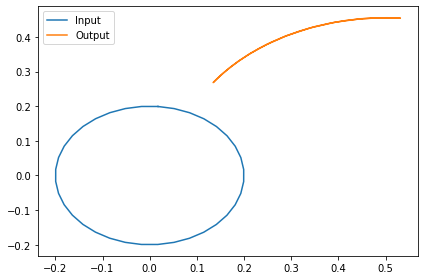

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

def getAssemblyDefinition(url: str):
  fixed_url = '/api/assemblies/d/did/w/wid/e/eid'
  element = OnshapeElement(url)
  base = element.base_url
  fixed_url = fixed_url.replace('did', element.did)
  fixed_url = fixed_url.replace('wid', element.wvmid)
  fixed_url = fixed_url.replace('eid', element.eid)

  method = 'GET'
  params = {}
  payload = {}
  headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
            'Content-Type': 'application/json'}

  response = client.api_client.request(method, url=base + fixed_url, query_params=params, headers=headers, body=payload)
  parsed = json.loads(response.data)
  return parsed


def clockwiseSpinZ(theta):
    m = [[np.cos(theta), np.sin(theta), 0, 0],
        [-np.sin(theta), np.cos(theta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]]
    return m


def rotate_input(assembly, partId: str, rotation: float): 
    url = 'https://cad.onshape.com/documents/9956cf02c4db09c32d653307/w/a08b90943f6b539764b5c942/e/a3566547896a300e872e6e80' 

    identity_matrix = [1, 0, 0, 0, 
                       0, 1, 0, 0,
                       0, 0, 1, 0,
                       0, 0, 0, 1]
    identity_matrix = np.reshape(identity_matrix, (4,4))
    occurrences = assembly['rootAssembly']['occurrences']
    occurrence = None
    for x in occurrences:
        if x['path'][0] == partId:
            occurrence = x
    if not occurrence: 
        print("Part not found!")
        return None
    
    rotMat = np.matmul(identity_matrix,clockwiseSpinZ(rotation))
    transformMat = np.matmul(identity_matrix,rotMat)

    fixed_url = '/api/assemblies/d/did/w/wid/e/eid/occurrencetransforms'
    element = OnshapeElement(url)
    base = element.base_url
    fixed_url = fixed_url.replace('did', element.did)
    fixed_url = fixed_url.replace('wid', element.wvmid)
    fixed_url = fixed_url.replace('eid', element.eid)

    method = 'POST'
    params = {}
    payload = {'isRelative': True,
               'occurrences': [occurrence],
               'transform': list(np.reshape(transformMat, -1))}
    headers = {'Accept': 'application/vnd.onshape.v1+json; charset=UTF-8;qs=0.1',
               'Content-Type': 'application/json'}

    response = client.api_client.request(method, url=base + fixed_url, 
                                         query_params=params, headers=headers, 
                                         body=payload)


def get_position(assembly, partId: str): 
    """
    This function parses through all the parts within the assembly 
    and returns the x and y positions of the position trackers specified 
    with the partId. 
    """
    for occ in assembly['rootAssembly']['occurrences']: 
        if occ['path'][0] == partId: 
            return occ['transform'][3], occ['transform'][7]
    print("Part not found!") 
    return None 


input_x_pos = [] 
input_y_pos = [] 
output_x_pos = [] 
output_y_pos = [] 

rotation_step = np.pi/18  # in radian 
URL = 'https://cad.onshape.com/documents/9956cf02c4db09c32d653307/w/a08b90943f6b539764b5c942/e/a3566547896a300e872e6e80'

assembly_info = getAssemblyDefinition(URL)
in_pos = get_position(assembly_info, 'MrKVHwm/CqMOEFTa7')
out_pos = get_position(assembly_info, 'M7jknQrPGALQtDQ4j')
if in_pos and out_pos: 
    input_x_pos.append(in_pos[0])
    input_y_pos.append(in_pos[1])
    output_x_pos.append(out_pos[0])
    output_y_pos.append(out_pos[1])
    for i in range(int(np.pi * 2 / rotation_step)): 
        # Rotate the input by rotation_step 
        rotate_input(assembly_info, 'MrKVHwm/CqMOEFTa7', rotation_step)
        # Get the x-y position of the input and output position trackers 
        assembly_info = getAssemblyDefinition(URL)
        in_pos = get_position(assembly_info, 'MrKVHwm/CqMOEFTa7')
        out_pos = get_position(assembly_info, 'M7jknQrPGALQtDQ4j')
        input_x_pos.append(in_pos[0])
        input_y_pos.append(in_pos[1])
        output_x_pos.append(out_pos[0])
        output_y_pos.append(out_pos[1])

# Plot the path 
fig, ax = plt.subplots()
ax.plot(input_x_pos, input_y_pos, label='Input')
ax.plot(output_x_pos, output_y_pos, label='Output')

plt.legend()
plt.tight_layout()
plt.show()